# NBA数据分析项目简介
**main.py位于第二个代码块中**

## 预测思路
获取数据之后，我们利用每支队伍过去的比赛情况与Elo等级分来判断每支比赛队伍的获胜概率。通过Team Per Game Stat，Opponent Per Game Stat，Miscellaneous Stat三张表格的数据作为某支队伍的比赛特征，预测比赛中哪支队伍会获胜。
### 关于Elo等级分
具体解释与计算公式可参考
- https://zh.wikipedia.org/wiki/%E7%AD%89%E7%BA%A7%E5%88%86
- https://baike.baidu.com/item/%E5%9F%83%E6%B4%9B%E7%AD%89%E7%BA%A7%E5%88%86%E7%B3%BB%E7%BB%9F/2359694

我们将根据elo等级分划分三个k值
```python
if winner_rank < 2100:
    k = 32
elif winner_rank >= 2100 and winner_rank < 2400:
    k = 24
else:
    k = 16
```

### 结果
运行代码块，比赛预测结果将写入"data\2022-2023_result.csv"文件内


Fitting on 1323 game samples..
Doing cross-validation..
Predicting on new schedule..


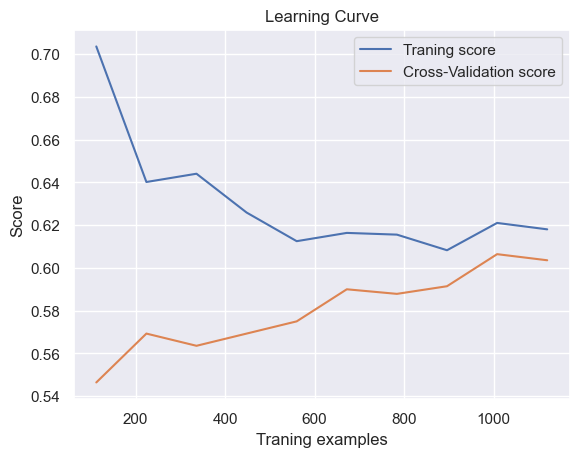

In [14]:
import pandas as pd
import math
import csv
import random
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.svm import SVC

base_elo = 1600
team_elos = {}
team_stats = {}
x = []
y = []


def plot_learning_curve():
    data_x, data_y = make_classification(
        n_samples=1400, n_classes=5, n_features=10, n_informative=8)  # 生成分类任务
    # 绘制学习曲线
    model = SVC(kernel="linear")
    train_sizes, train_scores, valid_scores = learning_curve(
        model, data_x, data_y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, random_state=0)
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # 开始绘图
    sns.set()
    sns.lineplot(x=train_sizes, y=train_scores_mean, label="Traning score")
    sns.lineplot(x=train_sizes, y=valid_scores_mean,
                 label="Cross-Validation score")
    plt.xlabel("Traning examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.show()


def initialize_data(Mstat, Ostat, Tstat):
    new_Mstat = Mstat.drop(['Rk', 'Arena'], axis=1)
    new_Ostat = Ostat.drop(['Rk', 'G', 'MP'], axis=1)
    new_Tstat = Tstat.drop(['Rk', 'G', 'MP'], axis=1)

    team_stats1 = pd.merge(new_Mstat, new_Ostat, how='left', on='Team')
    team_stats1 = pd.merge(team_stats1, new_Tstat, how='left', on='Team')
    return team_stats1.set_index('Team', inplace=False, drop=True)


def get_elo(team):
    try:
        return team_elos[team]
    except:
        team_elos[team] = base_elo
    # team_elos[team] = team_elos.get(team, base_elo)
    return team_elos[team]


def calc_elo(win_team, lose_team):
    winner_rank = get_elo(win_team)
    loser_rank = get_elo(lose_team)
    rank_diff = winner_rank-loser_rank
    exp = (rank_diff*(-1))/400
    odds = 1/(1+math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff
    return new_winner_rank, new_loser_rank


def build_dataSet(all_data):
    x = []
    skip = 0
    for index, row in all_data.iterrows():
        WTeam = row['WTeam']
        LTeam = row['LTeam']
        team1_elo = get_elo(WTeam)
        team2_elo = get_elo(LTeam)
        if row['WTeam'] == 'H':
            team1_elo += 100
        else:
            team2_elo += 10

        team1_features = [team1_elo]
        team2_features = [team2_elo]

        for key, value in team_stats.loc[WTeam].iteritems():
            team1_features.append(value)
        for key, value in team_stats.loc[LTeam].iteritems():
            team2_features.append(value)

        if random.random() > 0.5:
            x.append(team1_features+team2_features)
            y.append(0)
        else:
            x.append(team2_features+team1_features)
            y.append(1)

        if skip == 0:
            skip = 1

        new_winner_rank, new_loser_rank = calc_elo(WTeam, LTeam)
        team_elos[WTeam] = new_winner_rank
        team_elos[LTeam] = new_loser_rank

    return np.nan_to_num(x), y


def predict_winner(team_1, team_2, model):
    features = []

    features.append(get_elo(team_1))
    for key, value in team_stats.loc[team_1].iteritems():
        features.append(value)

    features.append(get_elo(team_2) + 100)
    for key, value in team_stats.loc[team_2].iteritems():
        features.append(value)

    features = np.nan_to_num(features)
    return model.predict_proba([features])


if __name__ == '__main__':

    Mstat = pd.read_csv('data\\2021-2022Miscellaneous Stats.csv')
    Ostat = pd.read_csv('data\\2021-2022Opponent Per Game Stats.csv')
    Tstat = pd.read_csv('data\\2021-2022Team Per Game Stats.csv')

    team_stats = initialize_data(Mstat, Ostat, Tstat)

    result_data = pd.read_csv('data\\2021-2022_result.csv')
    x, y = build_dataSet(result_data)

    print("Fitting on %d game samples.." % len(x))

    model = linear_model.LogisticRegression()
    model.fit(x, y)

    print("Doing cross-validation..")

    print('Predicting on new schedule..')
    schedule2223 = pd.read_csv('data\\2022-2023_schedule.csv')
    result = []
    for index, row in schedule2223.iterrows():
        team1 = row['Vteam']
        team2 = row['Hteam']
        pred = predict_winner(team1, team2, model)
        prob = pred[0][0]
        if prob > 0.5:
            winner = team1
            loser = team2
            result.append([winner, loser, prob])
        else:
            winner = team2
            loser = team1
            result.append([winner, loser, 1 - prob])
    plot_learning_curve()
    with open('data\\2022-2023_result.csv', 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["WTeam", "LTeam", "probability"])
        writer.writerows(result)
